## Sliding SEIR model


In [51]:
import sys

In [52]:
!{sys.executable} -m pip install --upgrade pip

In [53]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd


### Data loading


In [54]:
infected_dataset_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
recovered_dataset_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
deaths_dataset_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
countries_dataset_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv"

In [55]:
countries = pd.read_csv(countries_dataset_url)
infected_original = pd.read_csv(infected_dataset_url)
recovered_original = pd.read_csv(recovered_dataset_url)
deaths_original = pd.read_csv(deaths_dataset_url)

In [56]:
population = countries[countries['Province_State'].isnull()][['Country_Region','Population']].rename(columns={'Country_Region' : 'Country/Region'}).set_index('Country/Region')
infected = infected_original.groupby('Country/Region').sum().reset_index().set_index('Country/Region').join(population,on='Country/Region')
deaths = deaths_original.groupby('Country/Region').sum().reset_index().set_index('Country/Region').join(population,on='Country/Region')
recovered = recovered_original.groupby('Country/Region').sum().reset_index().set_index('Country/Region').join(population,on='Country/Region')

### Расчет данных по SEIR-модели

In [57]:
# The SEIR model differential equations.
def deriv_seir(y, t, N, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt,dIdt, dRdt

#Compute SEIR model starting from given numbers of infected/removed ppl
def seir_model(infected,removed,exposed,N,beta,gamma,sigma,ndays):
    t = np.linspace(0,ndays,ndays)
    y0 = N-infected-removed-exposed,infected,removed,exposed
    ret = odeint(deriv_seir, y0, t, args=(N, beta, gamma, sigma))
    return ret.T 


In [58]:
seir_model(1,1,1,100,1,1,1,1)

array([[97.],
       [ 1.],
       [ 1.],
       [ 1.]])

In [59]:

def s_model(V,R,E,N,beta,gamma,sigma):
    S,E,I,R = seir_model(V[0],R[0],E[0],N,beta,gamma,sigma,len(V))
    dV = np.diff(V)
    dI = np.diff(I + R + E/0.57)
    return np.linalg.norm(dV-dI)

def s_fit(V,R,E,N):
    res = minimize(lambda x:s_model(V,R,E,N,x,1/30,1/5),x0=0.5,method='powell')
    return res.x,1/30,1/5

def s_fit2(V,R,E,N):
    res = minimize(lambda x:s_model(V,R,E,N,x,1/20,1/5),x0=0.5,method='powell')
    return res.x,1/20,1/5

## Analysis of a Country

In [60]:
def s_make_frame(country_name,smooth_window=3,exposed_shift=5):
    exposed = infected.loc[country_name].shift(-exposed_shift)
    s_f = pd.DataFrame([infected.loc[country_name],recovered.loc[country_name],deaths.loc[country_name],exposed]).T
    population = s_f.iloc[-1,0]
    s_f = s_f.iloc[2:-1].reset_index()
    s_f.columns = ['Date','Infected','Recovered','Deaths','Exposed']
    s_f['Removed'] = s_f['Recovered']+s_f['Deaths']+s_f['Exposed']
    s_f["Date"] = pd.to_datetime(s_f["Date"],format="%m/%d/%y")
    for x in ['Infected','Recovered','Deaths','Exposed','Removed']:
        s_f[x+"_Av"] = s_f[x].rolling(window=smooth_window).mean()
    return population, s_f

def s_get_start_index(s_df):
    return s_df[s_df['Infected_Av']>1000].index[0]

pop, df = s_make_frame('Brazil',smooth_window=3)
df

,Date,Infected,Recovered,Deaths,Exposed,Removed,Infected_Av,Recovered_Av,Deaths_Av,Exposed_Av,Removed_Av
0,2020-01-22,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,2020-01-23,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,2020-01-24,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000,0.000000e+00,0.000000e+00
3,2020-01-25,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000,0.000000e+00,0.000000e+00
4,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
576,2021-08-20,20528099.0,0.0,573511.0,212559409.0,213132920.0,2.049340e+07,0.0,572604.666667,8.458609e+07,8.515869e+07
577,2021-08-21,20556487.0,0.0,574209.0,NaN,NaN,2.052627e+07,0.0,573453.666667,NaN,NaN
578,2021-08-22,20570891.0,0.0,574527.0,NaN,NaN,2.055183e+07,0.0,574082.333333,NaN,NaN
579,2021-08-23,20583994.0,0.0,574848.0,NaN,NaN,2.057046e+07,0.0,574528.000000,NaN,NaN


In [61]:
def s_compute_params(s_df,population, s_start_index, ndays=7):
    for i in range(s_start_index,len(s_df)-ndays):
        V = s_df['Infected_Av'][i:i+ndays].to_numpy()
        R = s_df['Removed_Av'][i:i+ndays].to_numpy()
        E = s_df['Exposed_Av'][i:i+ndays].to_numpy()
        beta,gamma,sigma = s_fit(V,R,E,population)
        s_df.loc[i,'Beta'] = beta
        s_df.loc[i,'Gamma'] = gamma
        s_df.loc[i,'Sigma'] = sigma


In [62]:
def s_analyze(country_name,truncate_frame=True,start_date=None,end_date=None):
    population, s_df = s_make_frame(country_name)
    n = s_get_start_index(s_df)
    s_compute_params(s_df,population,n)
    s_df['Rt'] = s_df['Beta'] / s_df['Gamma']
    # calculate sliding Rt
    s_df["Rt_mf"] = 0.0
    res = s_df["Rt_mf"].copy()
    #res1 = s_df["RtS"].copy()
    s_df["Rt_mf_Av"] = 0.0
    for i in range(4,len(s_df)-4):
      if s_df.iloc[i]['Infected']-s_df.iloc[i-4]['Infected'] != 0:
        #s_df.iloc[i,s_df.columns.get_loc('RtS')] = sum(s_df.iloc[i-4:i]['Infected'])/sum(s_df.iloc[i-8:i-4]['Infected'])
        #res[i] = (s_df.iloc[i+3]['Infected']-s_df.iloc[i]['Infected'])/(s_df.iloc[i]['Infected']-s_df.iloc[i-4]['Infected'])
        res[i] = (s_df.iloc[i+4]['Infected']-s_df.iloc[i+3]['Infected']+s_df.iloc[i+3]['Infected']-s_df.iloc[i+2]['Infected']
                  +s_df.iloc[i+2]['Infected']-s_df.iloc[i+1]['Infected']
                  +s_df.iloc[i+1]['Infected']-s_df.iloc[i]['Infected'])/(s_df.iloc[i]['Infected']-s_df.iloc[i-1]['Infected']
                                                                         +s_df.iloc[i-1]['Infected']-s_df.iloc[i-2]['Infected']
                                                                         +s_df.iloc[i-2]['Infected']-s_df.iloc[i-3]['Infected']
                                                                         +s_df.iloc[i-3]['Infected']-s_df.iloc[i-4]['Infected'])
        #res1[i] = res[i].rolling(window=4).mean()
    s_df["Rt_mf"] = res
    for x in ["Rt_mf"]:
        s_df[x+"_Av"] = s_df[x].rolling(window=14).mean()
    if truncate_frame:
      s_df = s_df.iloc[n:]
    if start_date:
      s_df = s_df[s_df['Date']>=start_date]
    if end_date:
      s_df = s_df[s_df['Date']<=end_date]
    return population, s_df

#def s_RtSAv(smooth_window=3): #интервал сглаживания данных по стране
#    for x in ['RtS']:
#        s_df[x+"_Av"] = s_df[x].rolling(window=smooth_window).mean()
#    return population, s_df

#def analyze(country_name,truncate_frame=True):
    #population, df = make_frame(country_name)
    #n = get_start_index(df)
    #compute_params(df,population,n)
    #df['Rt'] = df['Beta'] / df['Gamma']
    #return population, df.iloc[n:] if truncate_frame else df

#pop, s_df = s_analyze('Germany',end_date='2021-01-01')
pop, s_df = s_analyze('Korea, South',end_date='2020-12-31')
#pop, s_df = s_RtSAv(smooth_window=7)

In [63]:

s_df.tail(20)

,Date,Infected,Recovered,Deaths,Exposed,Removed,Infected_Av,Recovered_Av,Deaths_Av,Exposed_Av,Removed_Av,Beta,Gamma,Sigma,Rt,Rt_mf,Rt_mf_Av
325,2020-12-12,42766.0,31814.0,580.0,47515.0,79909.0,41762.666667,31488.000000,576.666667,46470.000000,78534.666667,0.032948,0.033333,0.2,0.988452,1.105879,1.216909
326,2020-12-13,43484.0,32102.0,587.0,48570.0,81259.0,42662.000000,31803.000000,581.666667,47512.666667,79897.333333,0.033098,0.033333,0.2,0.992939,1.190490,1.221108
327,2020-12-14,44364.0,32559.0,600.0,49665.0,82824.0,43538.000000,32158.333333,589.000000,48583.333333,81330.666667,0.033192,0.033333,0.2,0.995752,1.175517,1.213491
328,2020-12-15,45442.0,32947.0,612.0,50591.0,84150.0,44430.000000,32536.000000,599.666667,49608.666667,82744.333333,0.033219,0.033333,0.2,0.996555,1.139504,1.199686
329,2020-12-16,46453.0,33610.0,634.0,51460.0,85704.0,45419.666667,33038.666667,615.333333,50572.000000,84226.000000,0.033165,0.033333,0.2,0.994952,1.122322,1.186413
330,2020-12-17,47515.0,33982.0,645.0,52550.0,87177.0,46470.000000,33513.000000,630.333333,51533.666667,85677.000000,0.033104,0.033333,0.2,0.993124,0.978665,1.175101
331,2020-12-18,48570.0,34334.0,659.0,53533.0,88526.0,47512.666667,33975.333333,646.000000,52514.333333,87135.666667,0.033162,0.033333,0.2,0.994874,0.946267,1.163246
332,2020-12-19,49665.0,34722.0,674.0,54770.0,90166.0,48583.333333,34346.000000,659.333333,53617.666667,88623.000000,0.033207,0.033333,0.2,0.996214,0.915937,1.152176
333,2020-12-20,50591.0,35155.0,698.0,55902.0,91755.0,49608.666667,34737.000000,677.000000,54735.000000,90149.000000,0.033261,0.033333,0.2,0.997836,1.009908,1.148031
334,2020-12-21,51460.0,35928.0,722.0,56872.0,93522.0,50572.000000,35268.333333,698.000000,55848.000000,91814.333333,0.033184,0.033333,0.2,0.995530,1.125982,1.140580


Population = 51269183.0, Infection start date (>1000) = 2020-02-26


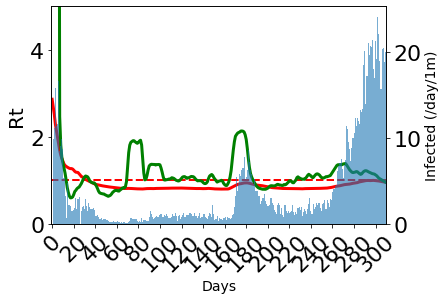

In [64]:
def plot(population,df,ax=None,plot_delta=True):
    n = 0 # get_start_index(df)
    start_date = df.iloc[n,0]
    if ax is None:
        print("Population = {}, Infection start date (>1000) = {}".format(population,start_date.date()))
    df['Days'] = df['Date'].apply(lambda x : (x-start_date).days)
    df['PI'] = df['Infected'] / population * 100
    df['Delta_Infected_Gr'] = (df['Infected'].diff()).clip(lower=0) / population * 1000000
    #plt.axhline(y = 1,linestyle='--', color='red')
    ax = df.plot('Days','Rt',ax=ax,legend=True,linewidth=3,color='red')
    ax.axhline(y = 1,linestyle='--', color='red',linewidth=2)
    ax.set_ylim(0,5,1)
    ax.set_ylabel('Rt')
    axe = df.plot('Days','Rt_mf_Av',ax=ax,legend=True,linewidth=3,color='green')
    if plot_delta:
      df.plot(x='Days',y='Delta_Infected_Gr',secondary_y=True,kind='bar',ax=ax,legend=False,width=1.0,alpha=0.6)#,xticks=df['Days'][::10])
    ax.set_xlabel('Days',fontsize=14)
    ax.set_xticks(df['Days'][::20])
    ax.set_xticklabels(df['Days'][::20], rotation = 45)
    ax.get_legend().remove()
    if plot_delta:
      ax.right_ax.set_ylabel('Infected (/day/1m)',fontsize=14)
plot(pop,s_df)


## Produce multiple-country plot

In [65]:
countries = [['India','Russia','Brazil'],['Finland','Norway','Sweden'],['US','Italy','Germany'],
             ['Spain','France','United Kingdom'], ['Israel','Japan','Korea, South']] 
    
# Compute all countries
country_data = {}
for x in sum(countries,[]):
    print("Computing data for {}".format(x))
    country_data[x] = s_analyze(x,end_date='2020-06-01')

Computing data for India
Computing data for Russia
Computing data for Brazil
Computing data for Finland
Computing data for Norway
Computing data for Sweden
Computing data for US
Computing data for Italy
Computing data for Germany
Computing data for Spain
Computing data for France
Computing data for United Kingdom
Computing data for Israel
Computing data for Japan
Computing data for Korea, South


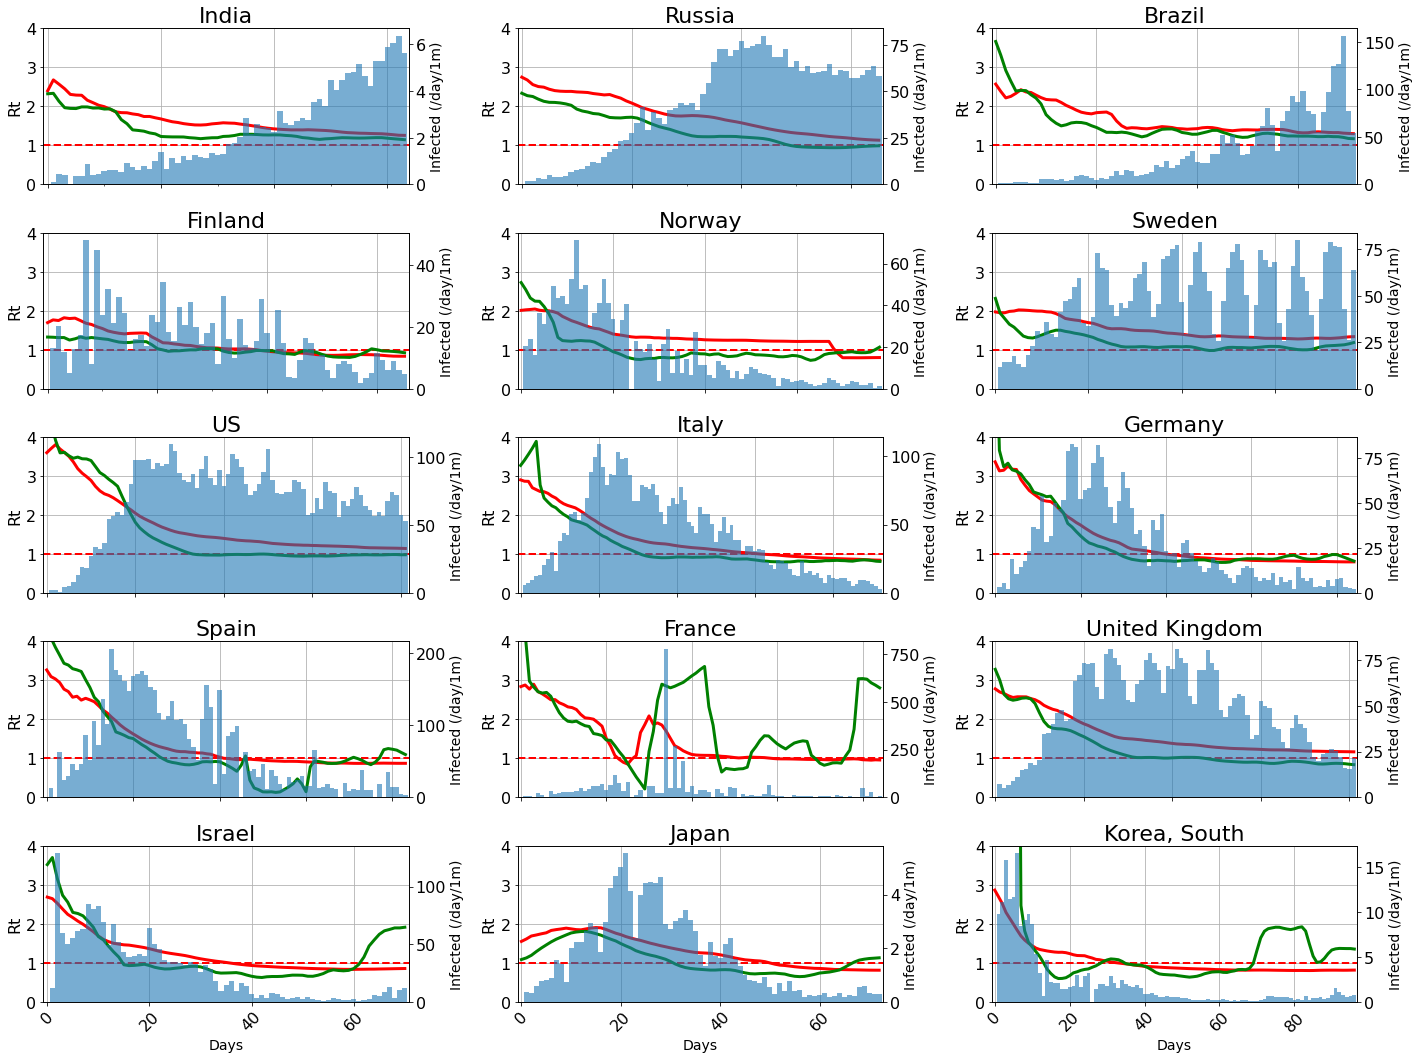

In [66]:
mx = max([len(x) for x in countries])
my = len(countries)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('font',size=16)
fig,ax = plt.subplots(my,mx,figsize=(20,15),sharex=False)
for i in range(my):
    for j in range(mx):
        c = countries[i][j]
        pop,df = country_data[c]
        plot(pop,df,ax=ax[i,j])
        ax[i,j].set_ylim(0,4,1)
        ax[i,j].set_title(c,fontsize=22)
        ax[i,j].axes.xaxis.set_visible(True)
        ax[i,j].grid(True)
        #plt.xticks(rotation='vertical')
fig.tight_layout()
plt.show()


In [67]:
r0df = [cd[1][['Days','Rt']].set_index('Days','Rt').rename(columns={'Rt':c }) for c,cd in country_data.items()]

In [68]:
from functools import reduce
r0df = reduce(lambda df,f : df.join(f), r0df)

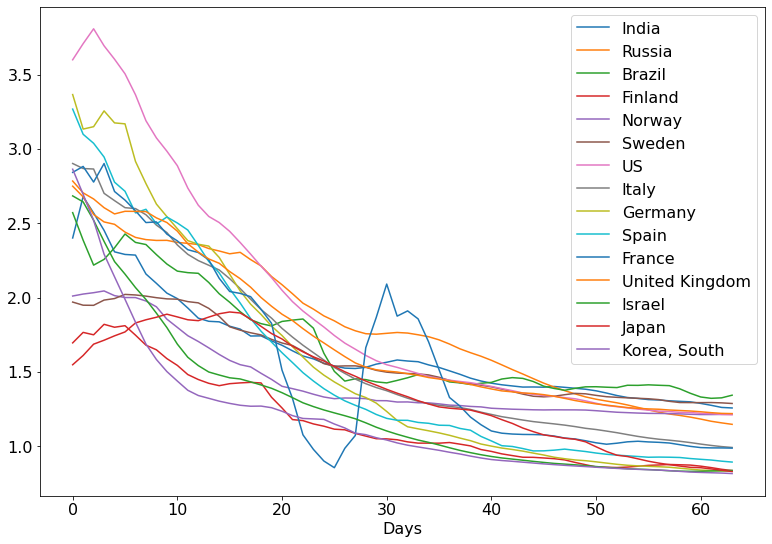

In [69]:
r0df.plot(figsize=(13,9))

## Adding Apple Mobility Index¶


In [70]:
apple_mobility_dataset_url = "https://covid19-static.cdn-apple.com/covid19-mobility-data/2115HotfixDev11/v3/en-us/applemobilitytrends-2021-08-23.csv"

!wget {apple_mobility_dataset_url}


--2021-08-25 21:36:10--  https://covid19-static.cdn-apple.com/covid19-mobility-data/2115HotfixDev11/v3/en-us/applemobilitytrends-2021-08-23.csv
Resolving covid19-static.cdn-apple.com (covid19-static.cdn-apple.com)... 23.205.104.20, 23.205.104.10, 2600:1408:5400:1::170c:9145, ...
Connecting to covid19-static.cdn-apple.com (covid19-static.cdn-apple.com)|23.205.104.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18249425 (17M) [text/csv]
Saving to: ‘applemobilitytrends-2021-08-23.csv.1’

applemobilitytrends 100%[===================>]  17.40M  --.-KB/s    in 0.1s    

2021-08-25 21:36:10 (153 MB/s) - ‘applemobilitytrends-2021-08-23.csv.1’ saved [18249425/18249425]



In [71]:
apple_mobility = pd.read_csv(apple_mobility_dataset_url)
apple_mobility.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,...,2021-07-15,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21,2021-07-22,2021-07-23,2021-07-24,2021-07-25,2021-07-26,2021-07-27,2021-07-28,2021-07-29,2021-07-30,2021-07-31,2021-08-01,2021-08-02,2021-08-03,2021-08-04,2021-08-05,2021-08-06,2021-08-07,2021-08-08,2021-08-09,2021-08-10,2021-08-11,2021-08-12,2021-08-13,2021-08-14,2021-08-15,2021-08-16,2021-08-17,2021-08-18,2021-08-19,2021-08-20,2021-08-21,2021-08-22,2021-08-23
0,country/region,Albania,driving,NaN,NaN,NaN,100.0,95.30,101.43,97.20,103.55,112.67,104.83,94.39,94.07,93.51,92.94,102.13,102.38,101.41,94.62,89.12,90.17,90.21,97.71,102.50,108.92,92.82,91.48,93.99,96.72,102.46,103.29,107.83,87.99,94.18,94.62,99.70,139.30,123.90,...,250.37,271.72,268.21,263.83,243.24,251.90,278.22,297.08,315.51,330.00,349.02,330.53,315.20,318.61,320.01,347.67,379.06,385.03,369.97,359.48,367.48,397.45,409.22,424.75,408.65,445.31,432.02,425.92,427.53,445.61,440.19,429.67,445.62,423.46,408.55,411.35,423.65,404.54,391.96,369.88
1,country/region,Albania,walking,NaN,NaN,NaN,100.0,100.68,98.93,98.46,100.85,100.13,82.13,95.65,97.78,95.39,94.24,93.73,97.06,77.27,83.37,82.73,84.39,88.19,90.79,88.70,79.32,87.12,88.06,99.40,85.84,94.63,99.74,81.41,90.19,90.45,94.16,95.69,109.21,108.40,...,236.29,244.01,234.80,202.00,223.75,226.65,260.72,265.93,284.18,273.39,253.82,291.86,270.02,276.76,269.64,285.67,295.10,281.36,321.45,305.67,315.95,322.90,357.65,336.55,316.97,359.91,362.22,373.30,361.54,355.05,355.78,318.93,379.10,368.40,360.98,363.16,364.09,342.81,296.97,334.54
2,country/region,Argentina,driving,NaN,NaN,NaN,100.0,97.07,102.45,111.21,118.45,124.01,95.44,95.13,95.42,97.66,99.42,113.34,118.23,91.31,93.37,91.12,92.35,96.74,111.24,123.96,89.01,91.66,89.18,94.49,95.98,111.12,121.53,89.23,96.42,96.97,101.68,104.90,122.91,127.62,...,87.62,110.41,119.97,76.00,84.39,104.62,87.91,95.23,116.22,122.68,75.03,79.49,81.46,83.51,87.12,107.44,121.10,76.60,69.50,73.32,75.93,79.32,107.97,130.56,60.93,67.70,72.97,77.70,83.78,115.24,137.72,103.02,83.04,74.66,79.03,79.81,105.67,124.29,78.22,70.24
3,country/region,Argentina,walking,NaN,NaN,NaN,100.0,95.11,101.37,112.67,116.72,114.14,84.54,101.37,106.12,104.91,102.56,104.88,98.83,73.64,94.27,93.86,92.20,96.00,98.99,97.42,67.21,95.18,96.25,100.39,99.10,105.00,106.45,73.12,104.20,105.87,111.47,113.20,128.75,103.47,...,75.18,89.34,90.67,50.82,73.40,92.07,75.92,82.94,100.50,90.21,52.75,70.94,71.21,70.80,76.64,89.37,92.05,53.20,64.84,70.74,68.89,70.38,93.11,100.36,39.50,59.79,67.47,69.68,74.27,93.41,109.55,74.71,59.85,70.33,73.13,72.57,95.44,95.20,56.09,65.87
4,country/region,Australia,driving,AU,NaN,NaN,100.0,102.98,104.21,108.63,109.08,89.00,99.35,103.53,106.80,107.40,115.65,109.66,88.59,85.18,95.91,99.40,99.92,103.04,103.73,85.73,93.39,95.83,98.63,102.40,107.46,106.55,86.33,98.78,100.08,103.28,106.19,116.62,115.36,93.51,...,96.91,82.88,67.98,79.44,78.88,78.63,80.76,84.23,76.98,61.62,72.95,76.87,89.22,93.40,98.98,97.09,70.08,80.33,82.22,85.13,86.43,78.32,66.63,55.40,75.12,78.55,80.66,83.20,87.03,83.47,68.26,77.28,77.72,79.80,81.58,86.38,78.02,63.23,74.92,75.37


In [72]:
apple_mobility['cou'] = np.where(np.logical_or(apple_mobility['geo_type']=='city',apple_mobility['geo_type']=='sub-region'),apple_mobility['country'],apple_mobility['region'])
apple = apple_mobility[apple_mobility['geo_type']!='county'].groupby('cou').mean().reset_index().set_index('cou')
apple.head()

,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,...,2021-07-15,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21,2021-07-22,2021-07-23,2021-07-24,2021-07-25,2021-07-26,2021-07-27,2021-07-28,2021-07-29,2021-07-30,2021-07-31,2021-08-01,2021-08-02,2021-08-03,2021-08-04,2021-08-05,2021-08-06,2021-08-07,2021-08-08,2021-08-09,2021-08-10,2021-08-11,2021-08-12,2021-08-13,2021-08-14,2021-08-15,2021-08-16,2021-08-17,2021-08-18,2021-08-19,2021-08-20,2021-08-21,2021-08-22,2021-08-23
cou,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Albania,100.0,97.990000,100.180000,97.830000,102.200000,106.400000,93.480000,95.020000,95.925000,94.450000,93.590000,97.930000,99.720000,89.340000,88.995000,85.925000,87.280000,89.200000,94.250000,95.600000,94.120000,89.970000,89.770000,96.695000,91.280000,98.545000,101.515000,94.620000,89.090000,92.315000,94.390000,97.695000,124.255000,116.150000,106.965000,99.435000,87.735000,84.830000,90.845000,97.070000,...,243.330000,257.865000,251.505000,232.915000,233.495000,239.275000,269.470000,281.505000,299.845000,301.695000,301.420000,311.195000,292.610000,297.685000,294.825000,316.670000,337.080000,333.195000,345.710000,332.575000,341.715000,360.175000,383.435000,380.650000,362.810000,402.610000,397.120000,399.610000,394.535000,400.330000,397.985000,374.300000,412.360000,395.930000,384.765000,387.255000,393.870000,373.675000,344.465000,352.210000
Argentina,100.0,97.882500,102.805000,110.887500,112.357500,106.507500,79.445000,95.985000,98.055000,101.370000,102.007500,106.675000,99.000000,74.862500,92.042500,94.040000,93.245000,101.682500,107.800000,105.562500,74.067500,93.990000,96.640000,101.550000,101.715000,111.482500,115.065000,80.487500,104.127500,108.540000,116.417500,119.945000,136.432500,118.835000,78.900000,97.510000,115.390000,114.595000,117.120000,135.047500,...,84.065000,101.367500,101.440000,61.045000,78.210000,96.795000,83.287500,90.730000,106.452500,98.425000,59.665000,74.157500,77.050000,77.477500,83.100000,98.772500,102.145000,63.342500,67.022500,73.540000,74.920000,75.940000,101.920000,113.470000,46.387500,62.455000,71.490000,75.615000,80.487500,103.157500,115.860000,83.437500,68.995000,72.655000,78.472500,77.335000,99.992500,102.900000,67.697500,68.995000
Australia,100.0,102.183659,103.196341,105.036341,105.119268,90.599268,99.195122,103.603171,106.546098,105.747317,109.892927,104.526585,89.295610,81.097561,97.310244,101.865122,102.000976,102.745610,101.921220,89.413659,97.915366,99.211951,102.092195,102.781951,105.036098,108.093659,88.966341,98.967805,104.528293,106.400244,108.344878,116.781707,119.002195,100.380732,105.721951,108.882927,112.067561,115.025122,117.608537,123.303415,...,98.047561,93.091220,81.388293,87.130244,83.364634,78.236829,78.456341,78.683415,80.062439,67.909512,72.302927,75.410488,86.177561,91.150488,94.877561,96.197317,74.915122,79.950244,84.212927,87.742683,88.550976,85.143171,82.265122,70.613659,80.926098,83.277073,83.393902,86.461951,85.777561,88.627805,76.813415,77.034634,75.239268,76.354634,80.288780,85.335122,85.555610,72.118049,76.047317,77.540244
Austria,100.0,100.079048,103.935238,106.959048,117.024762,116.633810,97.594286,99.574286,103.968571,103.753810,107.781905,124.255238,124.009048,99.964286,102.783810,103.662381,104.228095,106.639524,123.947143,137.896667,107.169524,112.474286,112.623810,113.250000,110.313333,130.251905,146.283810,111.696667,112.518095,114.092381,111.433333,114.076667,140.522381,159.736667,116.801905,116.414286,116.576667,117.178095,116.853333,138.382857,...,168.719524,184.282381,175.244762,163.344762,172.9

In [73]:
country_mapping = { 'US' : 'United States', 'China' : None, 'Korea, South' : 'Republic of Korea' }

In [74]:
import sympy as sym

In [75]:
def add_apple_index(df,country_name):
    country_name = country_mapping.get(country_name,country_name)
    if country_name is None:
        df["dRt/dt"] = 0
        df["Rt_shift_5"] = 0
        df['AppleIndex'] = 0
        df['AppleIndexAv'] = 0
        return df
    start_date = df.iloc[0]['Date']
    tdf = apple.loc[country_name].T.reset_index().rename(columns={'index':'Date', country_name : 'AppleIndex'})
    tdf["Date"] = pd.to_datetime(tdf["Date"],format="%Y-%m-%d")
    df["dRt/dt"] = df["Rt"].diff().rolling(window=7).mean()
    df["Rt_shift_5"] = df["Rt"].shift(5)
    tdf["AppleIndexAv"] = (tdf["AppleIndex"]/100).rolling(window=7).mean()
    tdf = tdf[tdf['Date']>=start_date].set_index('Date')
    return df.join(tdf,on='Date')


In [76]:
country_datax = { k : (d[0],add_apple_index(d[1],k)) for k,d in country_data.items() }
country_datax['Russia'][1].head(15)

,Date,Infected,Recovered,Deaths,Exposed,Removed,Infected_Av,Recovered_Av,Deaths_Av,Exposed_Av,Removed_Av,Beta,Gamma,Sigma,Rt,Rt_mf,Rt_mf_Av,Days,PI,Delta_Infected_Gr,dRt/dt,Rt_shift_5,AppleIndex,AppleIndexAv
66,2020-03-28,1264.0,49.0,4.0,3548.0,3601.0,1046.666667,44.000000,3.666667,2887.333333,2935.000000,0.091628,0.033333,0.2,2.748849,1.967490,2.336927,0,0.000866,NaN,NaN,NaN,61.550,0.823803
67,2020-03-29,1534.0,64.0,8.0,4149.0,4221.0,1278.000000,52.666667,5.333333,3491.333333,3549.333333,0.089232,0.033333,0.2,2.676955,2.299087,2.275234,1,0.001051,1.850146,NaN,NaN,51.454,0.782129
68,2020-03-30,1836.0,66.0,9.0,4731.0,4806.0,1544.666667,59.666667,7.000000,4142.666667,4209.333333,0.085283,0.033333,0.2,2.558499,2.322289,2.253324,2,0.001258,2.069422,NaN,NaN,45.342,0.723011
69,2020-03-31,2337.0,121.0,17.0,5389.0,5527.0,1902.333333,83.666667,11.333333,4756.333333,4851.333333,0.083612,0.033333,0.2,2.508356,1.840123,2.186003,3,0.001601,3.433048,NaN,NaN,39.639,0.658714
70,2020-04-01,2777.0,190.0,24.0,6343.0,6557.0,2316.666667,125.666667,16.666667,5487.666667,5630.000000,0.083080,0.033333,0.2,2.492405,1.726371,2.130744,4,0.001903,3.015052,NaN,NaN,32.567,0.581386
71,2020-04-02,3548.0,235.0,30.0,7497.0,7762.0,2887.333333,182.000000,23.666667,6409.666667,6615.333333,0.081339,0.033333,0.2,2.440182,1.387786,2.104346,5,0.002431,5.283194,NaN,2.748849,32.832,0.505849
72,2020-04-03,4149.0,281.0,34.0,8672.0,8987.0,3491.333333,235.333333,29.333333,7504.000000,7768.666667,0.080143,0.033333,0.2,2.404303,1.447471,2.101690,6,0.002843,4.118287,NaN,2.676955,35.484,0.426954
73,2020-04-04,4731.0,333.0,43.0,10131.0,10507.0,4142.666667,283.000000,35.666667,8766.666667,9085.333333,0.079649,0.033333,0.2,2.389465,1.646199,2.088323,7,0.003242,3.988092,-0.051341,2.558499,33.716,0.387191
74,2020-04-05,5389.0,355.0,45.0,11917.0,12317.0,4756.333333,323.000000,40.666667,10240.000000,10603.666667,0.079464,0.033333,0.2,2.383911,1.815467,2.064428,8,0.003693,4.508873,-0.041863,2.508356,32.935,0.360736
75,2020-04-06,6343.0,406.0,47.0,13584.0,14037.0,5487.666667,364.666667,45.000000,11877.333333,12287.000000,0.079484,0.033333,0.2,2.384522,1.994275,2.028155,9,0.004346,6.537181,-0.024854,2.492405,37.774,0.349924


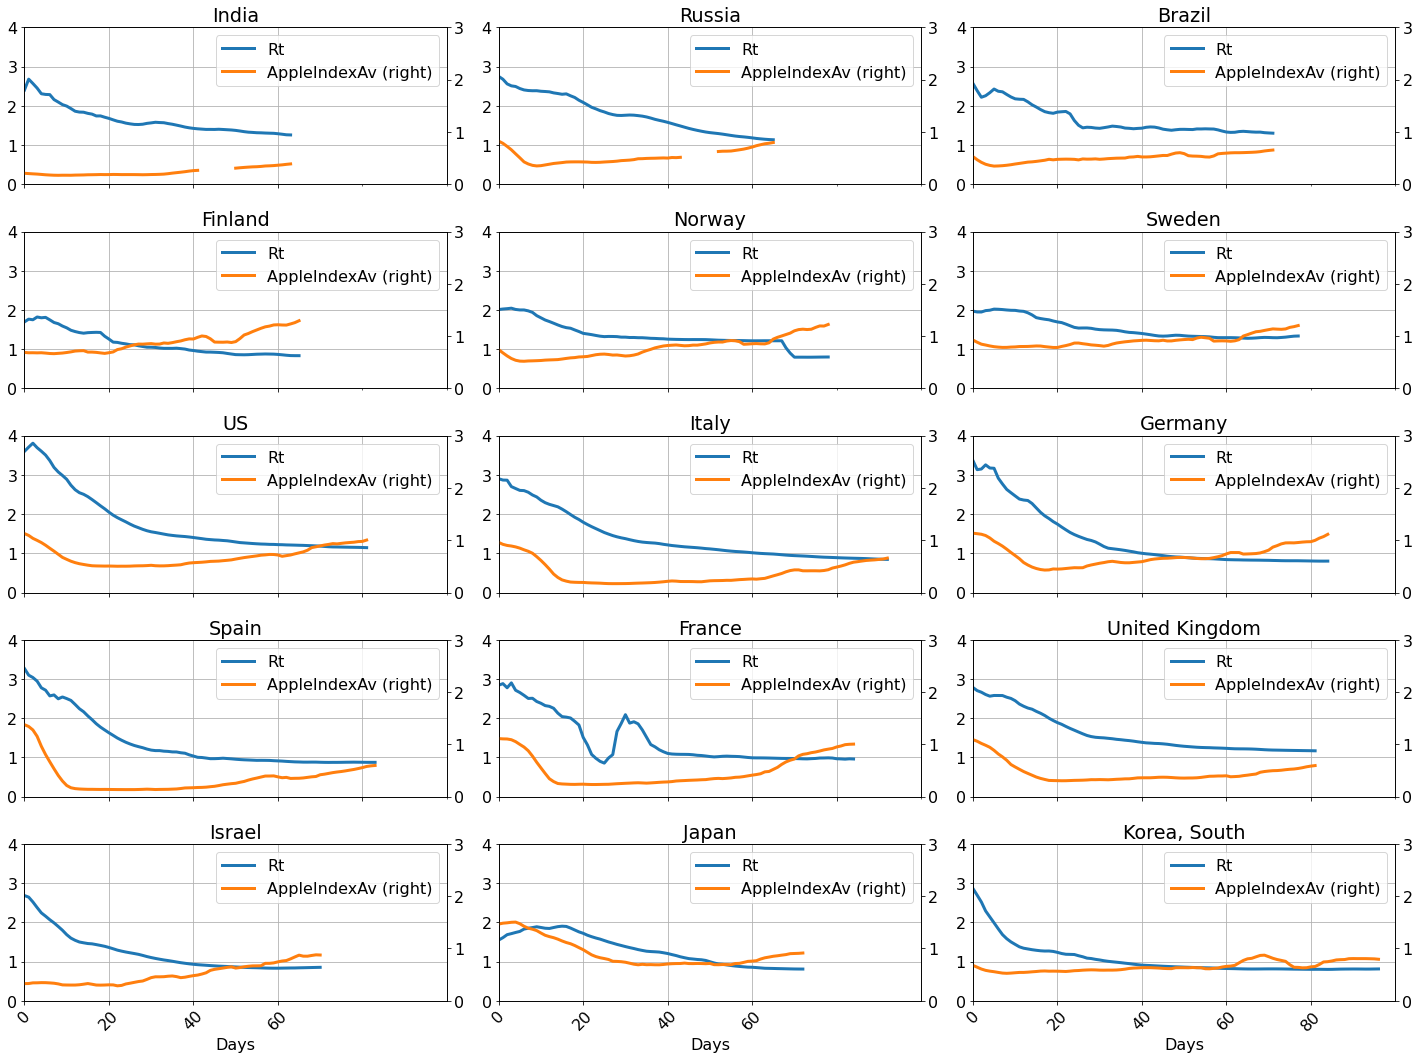

In [77]:
mx = max([len(x) for x in countries])
my = len(countries)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('font',size=16)
fig,ax = plt.subplots(my,mx,figsize=(20,15),sharex=False)
for i in range(my):
    for j in range(mx):
        c = countries[i][j]
        pop,df = country_datax[c]
        df["Rt_shift_5"] = df["Rt"].shift(5)
        axe=df.plot('Days','Rt',ax=ax[i,j],linewidth=3,)
        axe.set_xlim(0, 100)
        axe.set_ylim(0, 4)
        axe.set_title(c,fontsize=24)
        ax3 = df.plot('Days','AppleIndexAv',secondary_y=True,ax=axe,legend=True,xticks=df['Days'][::20], linewidth=3,)
        ax3.set_ylim(0, 3)
        ax[i,j].grid(True)
        ax[i,j].set_xticklabels(df['Days'][::20], rotation = 45)
        ax[i,j].set_title(c)
fig.tight_layout()
plt.show()

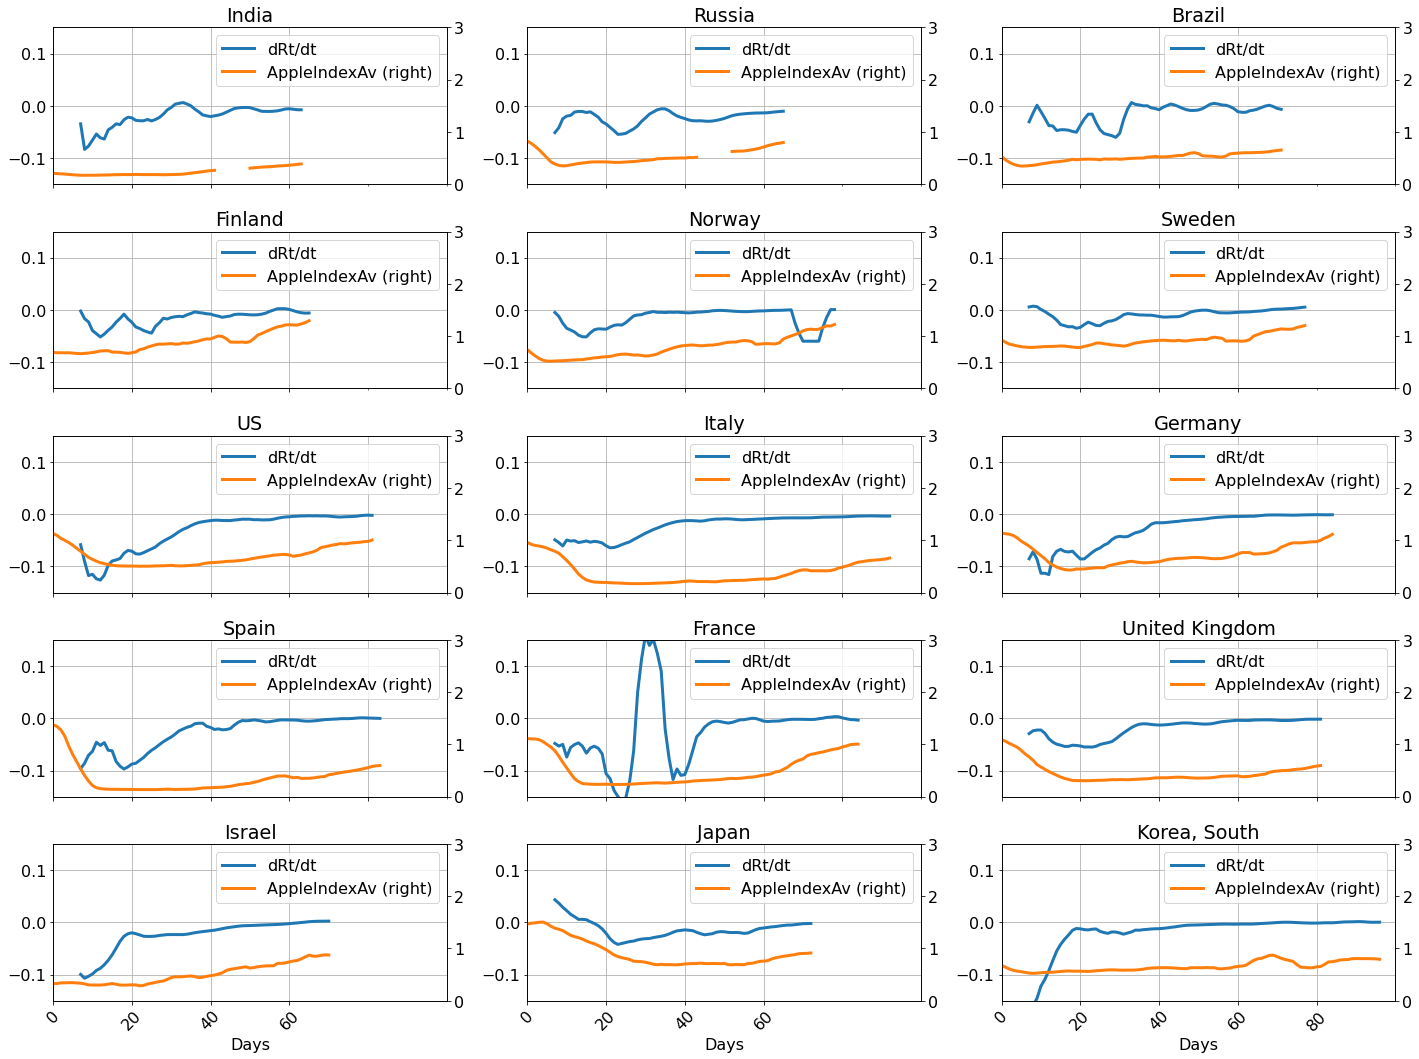

In [78]:
mx = max([len(x) for x in countries])
my = len(countries)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('font',size=16)
fig,ax = plt.subplots(my,mx,figsize=(20,15),sharex=False)
for i in range(my):
    for j in range(mx):
        c = countries[i][j]
        pop,df = country_datax[c]
        axe=df.plot('Days','dRt/dt',ax=ax[i,j],linewidth=3,)
        axe.set_xlim(0, 100)
        axe.set_ylim(-0.15, 0.15)
        axe.set_title(c,fontsize=24)
        ax3 = df.plot('Days','AppleIndexAv',secondary_y=True,ax=axe,legend=True,xticks=df['Days'][::20], linewidth=3,)
        ax3.set_ylim(0, 3)
        ax[i,j].grid(True)
        ax[i,j].set_xticklabels(df['Days'][::20], rotation = 45)
        ax[i,j].set_title(c)
fig.tight_layout()
plt.show()

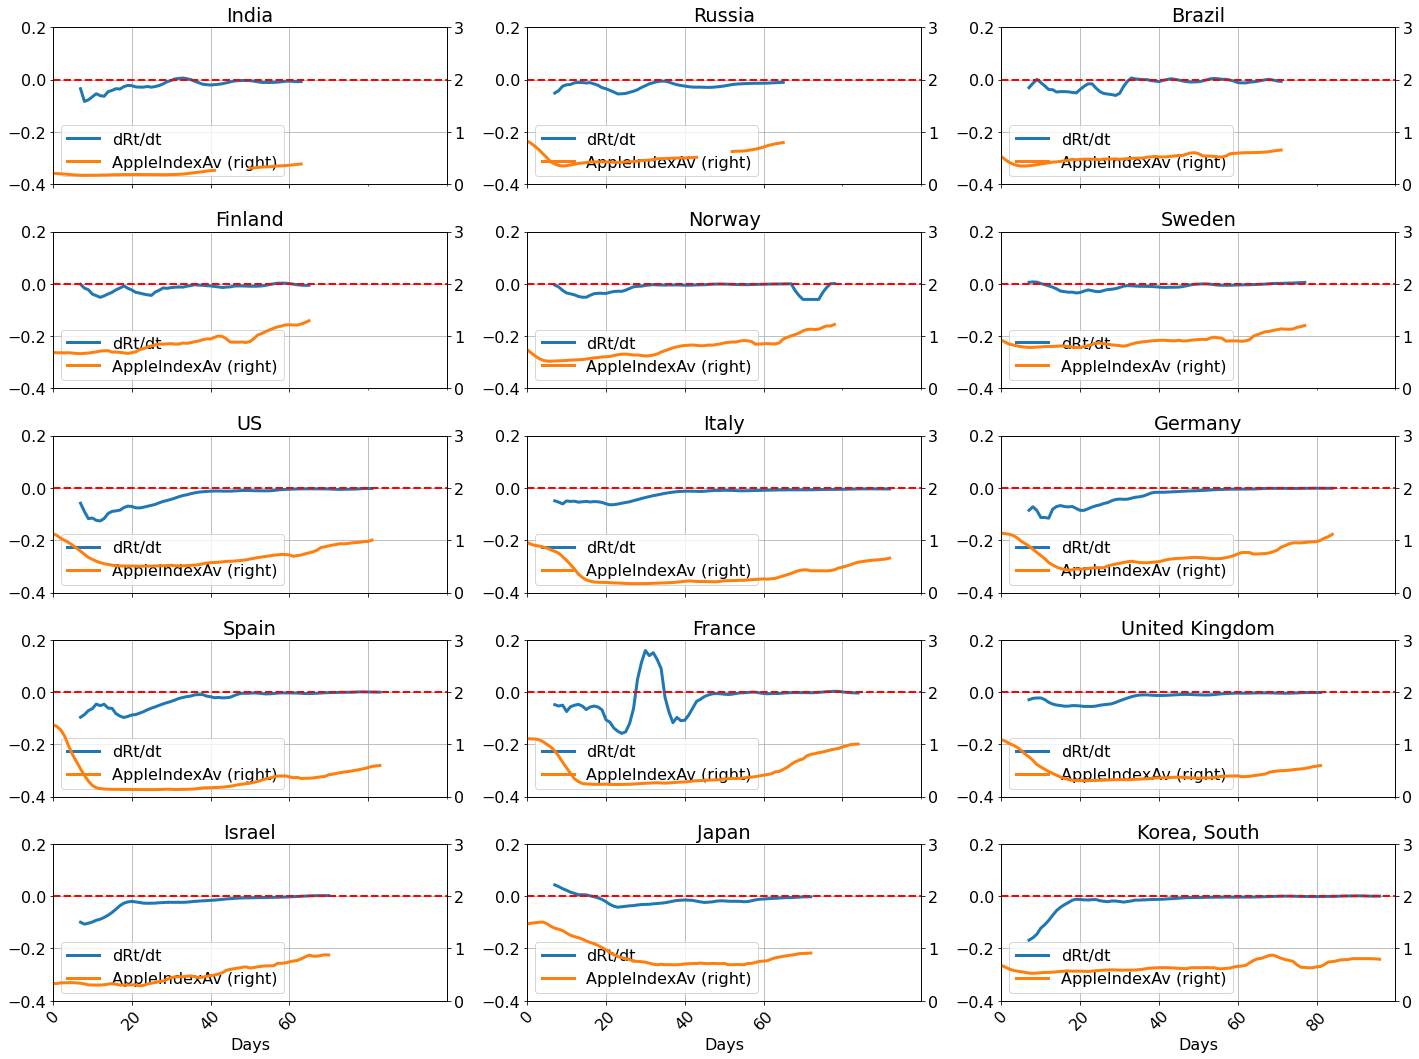

In [79]:
mx = max([len(x) for x in countries])
my = len(countries)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('font',size=16)
fig,ax = plt.subplots(my,mx,figsize=(20,15),sharex=False)
for i in range(my):
    for j in range(mx):
        c = countries[i][j]
        pop,df = country_datax[c]
        axe=df.plot('Days','dRt/dt',ax=ax[i,j],linewidth=3,)
        axe.axhline(y = 0,linestyle='--', color='red',linewidth=2)
        axe.set_xlim(0, 100)
        axe.set_ylim(-0.4, 0.2)
        axe.set_title(c,fontsize=24)
        ax3 = df.plot('Days','AppleIndexAv',secondary_y=True,ax=axe,legend=True,xticks=df['Days'][::20], linewidth=3,)
        ax3.set_ylim(0, 3)
        ax[i,j].grid(True)
        ax[i,j].set_xticklabels(df['Days'][::20], rotation = 45)
        ax[i,j].set_title(c)
fig.tight_layout()
plt.show()

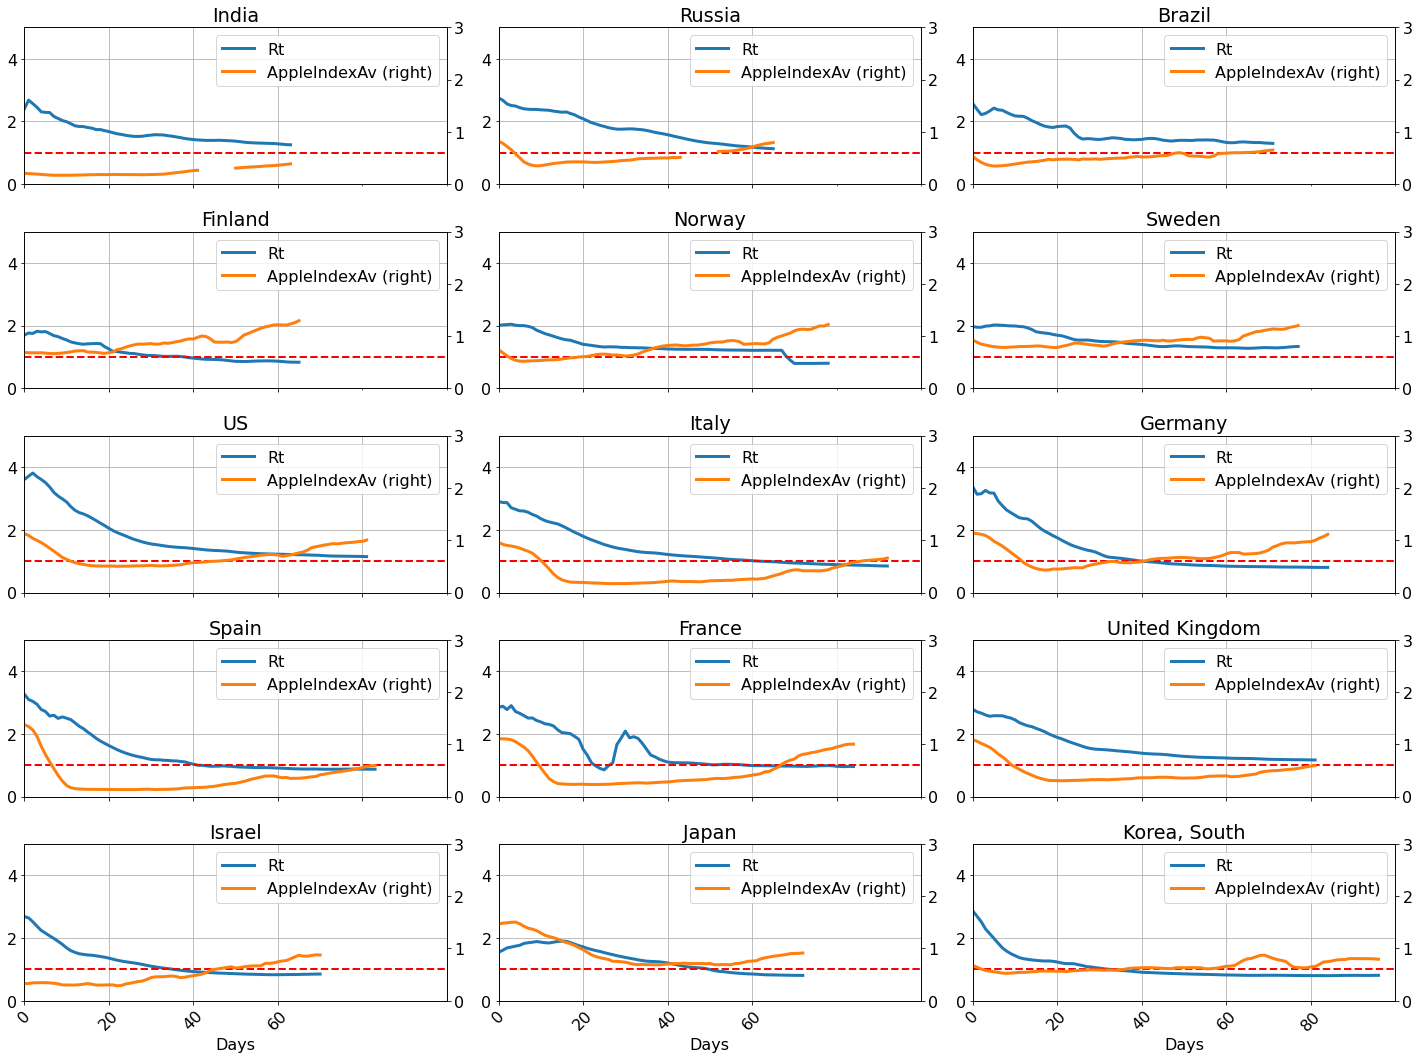

In [80]:
mx = max([len(x) for x in countries])
my = len(countries)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('font',size=16)
fig,ax = plt.subplots(my,mx,figsize=(20,15),sharex=False)
for i in range(my):
    for j in range(mx):
        c = countries[i][j]
        pop,df = country_datax[c]
        axe=df.plot('Days','Rt',ax=ax[i,j],linewidth=3,)
        axe.axhline(y = 1,linestyle='--', color='red',linewidth=2)
        axe.set_xlim(0, 100)
        axe.set_ylim(0, 5, 1)
        axe.set_title(c,fontsize=24)
        ax3 = df.plot('Days','AppleIndexAv',secondary_y=True,ax=axe,legend=True,xticks=df['Days'][::20], linewidth=3,)
        ax3.set_ylim(0, 3)
        ax[i,j].grid(True)
        ax[i,j].set_xticklabels(df['Days'][::20], rotation = 45)
        ax[i,j].set_title(c)
        #plt.xticks(rotation = 90)
fig.tight_layout()
plt.show()

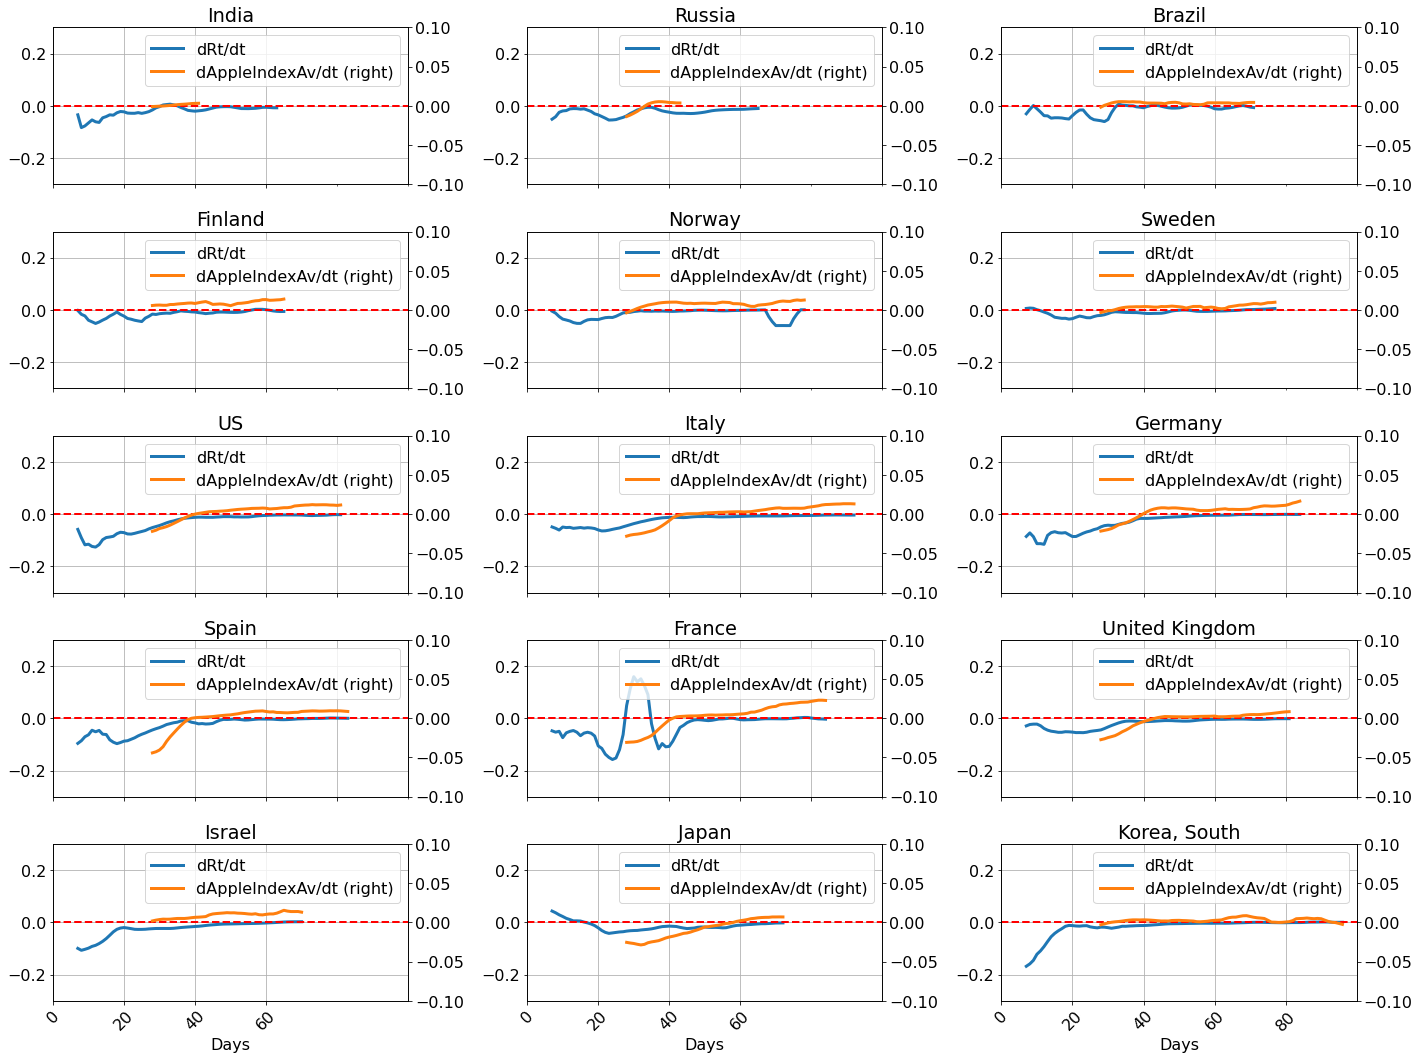

In [81]:
mx = max([len(x) for x in countries])
my = len(countries)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('font',size=16)
fig,ax = plt.subplots(my,mx,figsize=(20,15),sharex=False)
for i in range(my):
    for j in range(mx):
        c = countries[i][j]
        pop,df = country_datax[c]
        df["dAppleIndexAv/dt"] = df["AppleIndexAv"].diff().rolling(window=28).mean()
        axe=df.plot('Days','dRt/dt',ax=ax[i,j],linewidth=3,)
        axe.axhline(y = 0,linestyle='--', color='red',linewidth=2)
        axe.set_xlim(0, 100)
        axe.set_ylim(-0.3, 0.3)
        axe.set_title(c,fontsize=24)
        ax3 = df.plot('Days','dAppleIndexAv/dt',secondary_y=True,ax=axe,legend=True,xticks=df['Days'][::20], linewidth=3,)
        ax3.set_ylim(-0.1, 0.1)
        ax[i,j].grid(True)
        ax[i,j].set_xticklabels(df['Days'][::20], rotation = 45)
        ax[i,j].set_title(c)
fig.tight_layout()
plt.show()

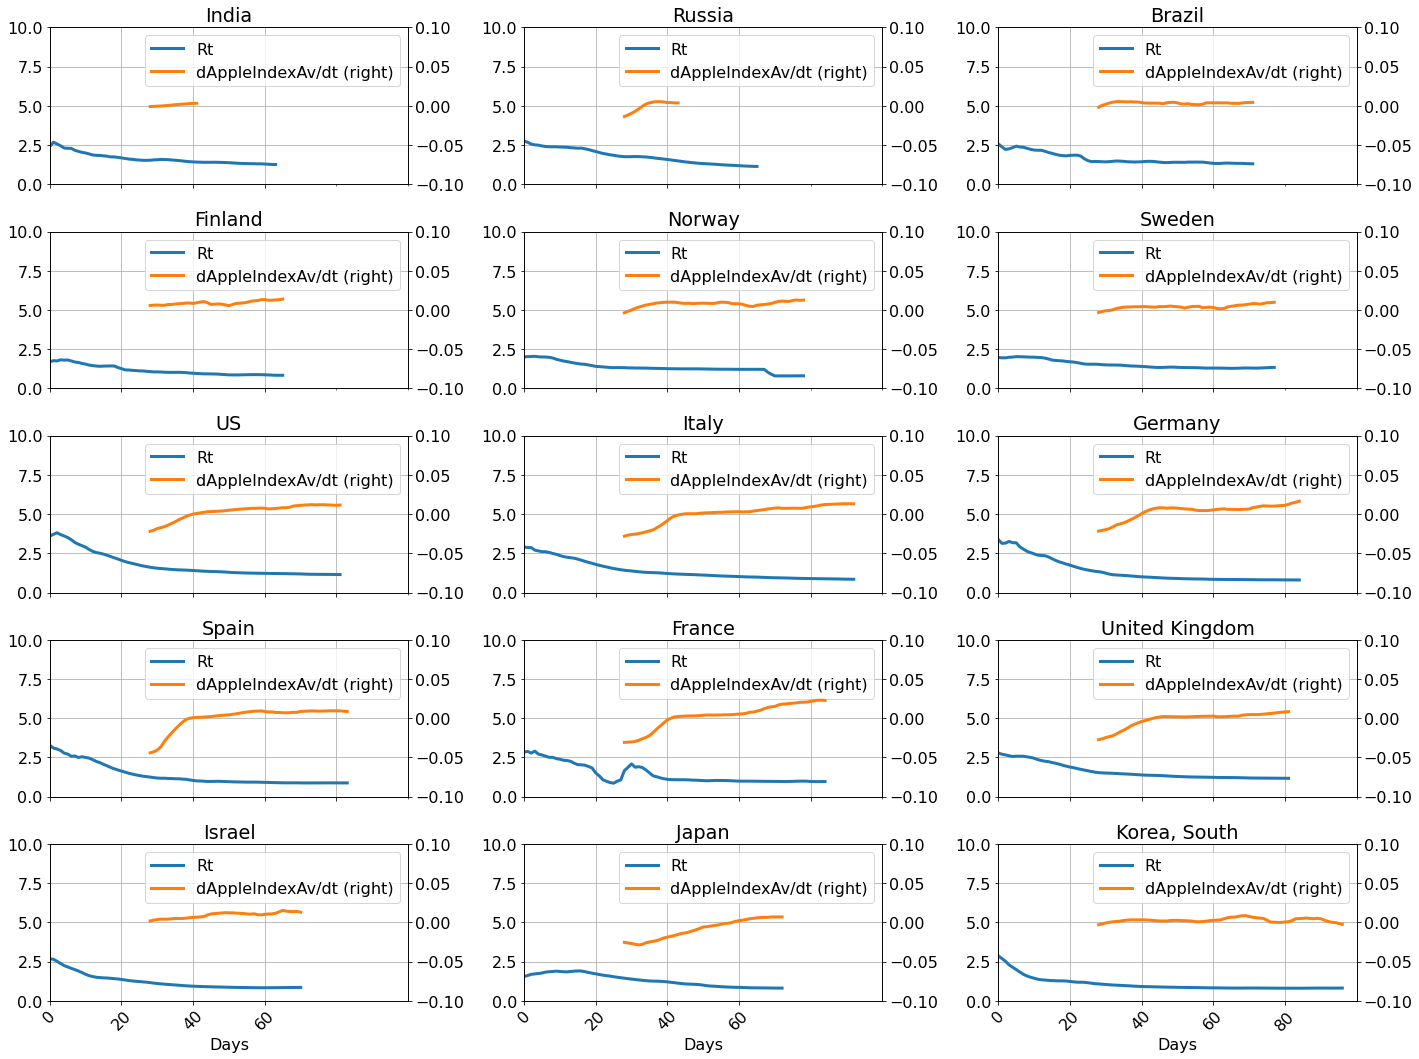

In [82]:
mx = max([len(x) for x in countries])
my = len(countries)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('font',size=16)
fig,ax = plt.subplots(my,mx,figsize=(20,15),sharex=False)
for i in range(my):
    for j in range(mx):
        c = countries[i][j]
        pop,df = country_datax[c]
        df["dAppleIndexAv/dt"] = df["AppleIndexAv"].diff().rolling(window=28).mean()
        axe=df.plot('Days','Rt',ax=ax[i,j],linewidth=3,)
        axe.set_xlim(0, 100)
        axe.set_ylim(0, 10)
        axe.set_title(c,fontsize=24)
        ax3 = df.plot('Days','dAppleIndexAv/dt',secondary_y=True,ax=axe,legend=True,xticks=df['Days'][::20], linewidth=3,)
        ax3.set_ylim(-0.1, 0.1)
        ax[i,j].grid(True)
        ax[i,j].set_xticklabels(df['Days'][::20], rotation = 45)
        ax[i,j].set_title(c)
fig.tight_layout()
plt.show()

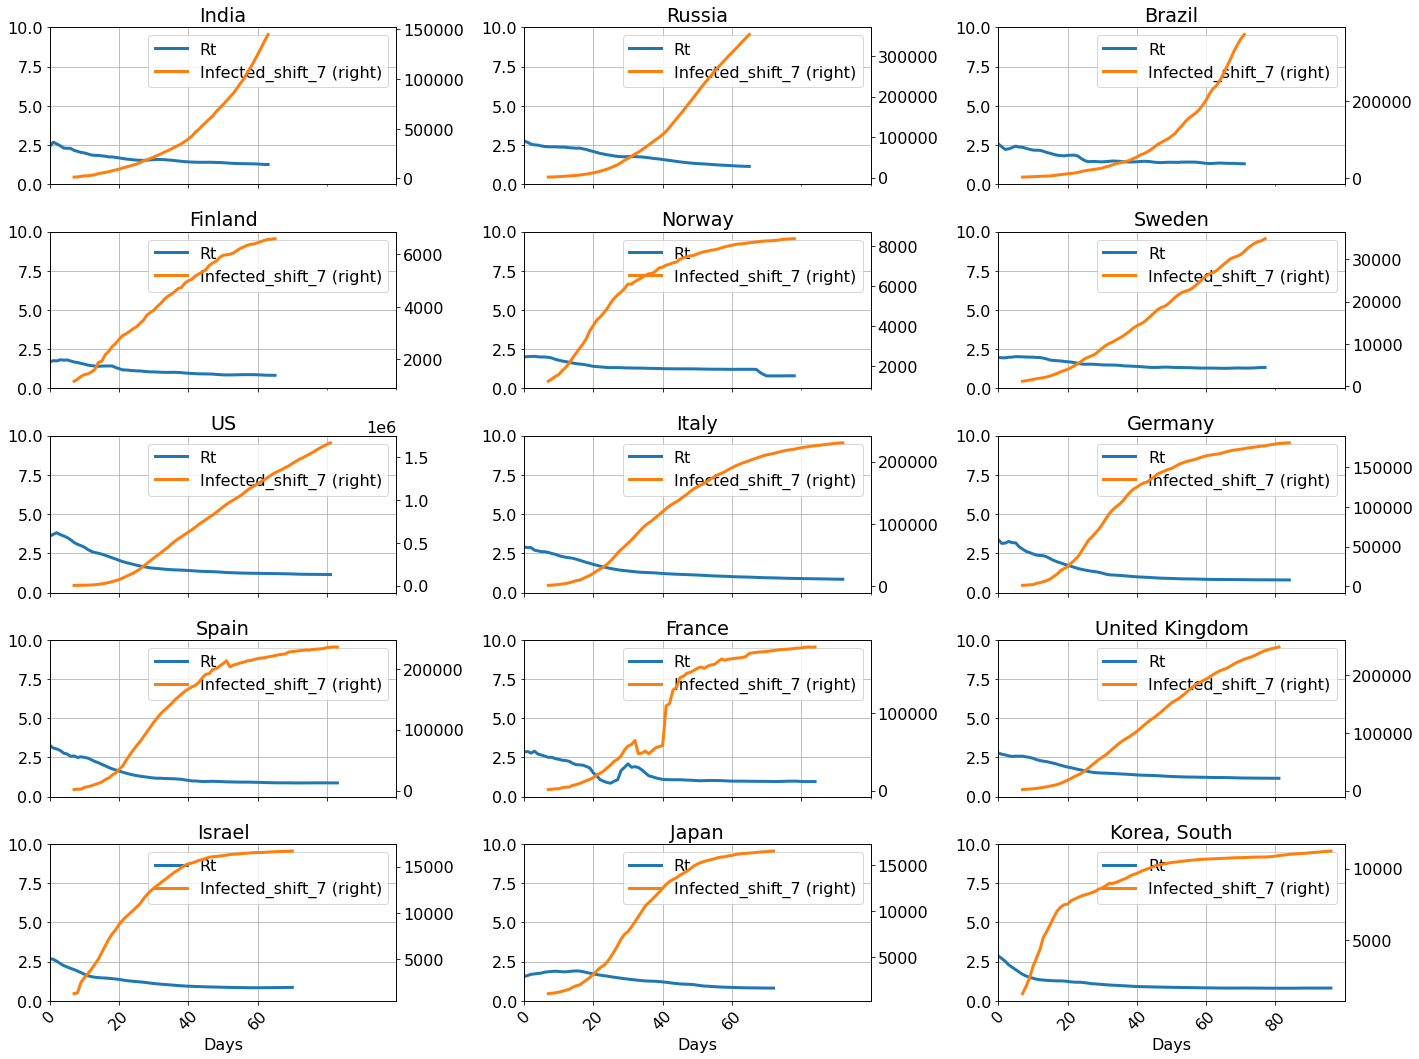

In [83]:
mx = max([len(x) for x in countries])
my = len(countries)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('font',size=16)
fig,ax = plt.subplots(my,mx,figsize=(20,15),sharex=False)
for i in range(my):
    for j in range(mx):
        c = countries[i][j]
        pop,df = country_datax[c]
        df["Infected_shift_7"] = df["Infected"].shift(7)
        axe=df.plot('Days','Rt',ax=ax[i,j],linewidth=3,)
        axe.set_xlim(0, 100)
        axe.set_ylim(0, 10)
        axe.set_title(c,fontsize=24)
        ax3 = df.plot('Days','Infected_shift_7',secondary_y=True,ax=axe,legend=True,xticks=df['Days'][::20], linewidth=3,)
        #ax3.set_ylim(-0.1, 0.1)
        ax[i,j].grid(True)
        ax[i,j].set_xticklabels(df['Days'][::20], rotation = 45)
        ax[i,j].set_title(c)
fig.tight_layout()
plt.show()


In [84]:
df.head()

,Date,Infected,Recovered,Deaths,Exposed,Removed,Infected_Av,Recovered_Av,Deaths_Av,Exposed_Av,Removed_Av,Beta,Gamma,Sigma,Rt,Rt_mf,Rt_mf_Av,Days,PI,Delta_Infected_Gr,dRt/dt,Rt_shift_5,AppleIndex,AppleIndexAv,dAppleIndexAv/dt,Infected_shift_7
35,2020-02-26,1261.0,22.0,12.0,4335.0,4369.0,1023.666667,20.666667,10.000000,3740.333333,3771.000000,0.095430,0.033333,0.2,2.862914,2.989130,36.866008,0,0.002460,NaN,NaN,NaN,60.306364,0.677468,NaN,NaN
36,2020-02-27,1766.0,22.0,13.0,5186.0,5221.0,1334.666667,22.000000,11.666667,4419.000000,4452.666667,0.089808,0.033333,0.2,2.694241,2.207045,36.976035,1,0.003445,9.849972,NaN,NaN,56.463182,0.642577,NaN,NaN
37,2020-02-28,2337.0,22.0,13.0,5621.0,5656.0,1788.000000,22.000000,12.666667,5047.333333,5082.000000,0.083964,0.033333,0.2,2.518919,1.894282,36.897055,2,0.004558,11.137295,NaN,NaN,54.267727,0.607016,NaN,NaN
38,2020-02-29,3150.0,27.0,16.0,6088.0,6131.0,2417.666667,23.666667,14.000000,5631.666667,5669.333333,0.076376,0.033333,0.2,2.291277,1.137138,36.978279,3,0.006144,15.857479,NaN,NaN,50.848636,0.581856,NaN,NaN
39,2020-03-01,3736.0,30.0,17.0,6593.0,6640.0,3074.333333,26.333333,15.333333,6100.666667,6142.333333,0.071305,0.033333,0.2,2.139155,0.950303,31.689015,4,0.007287,11.429868,NaN,NaN,53.300455,0.567071,NaN,NaN


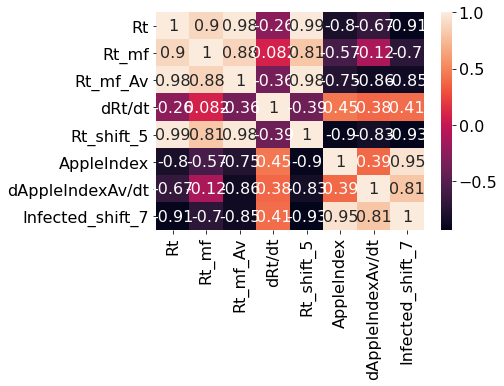

In [85]:
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = country_datax['Russia'][1].drop(['Date','Infected','Recovered','Deaths', 'Exposed',	'Removed', 'Infected_Av',	'Recovered_Av',	'Deaths_Av',	'Exposed_Av',	'Removed_Av',	'Beta',	'Gamma',	'Sigma',
                                              'Days','PI','Delta_Infected_Gr','AppleIndexAv'], axis='columns').corr()
corrMatrix.head()
sn.heatmap(corrMatrix, annot=True)
plt.show()

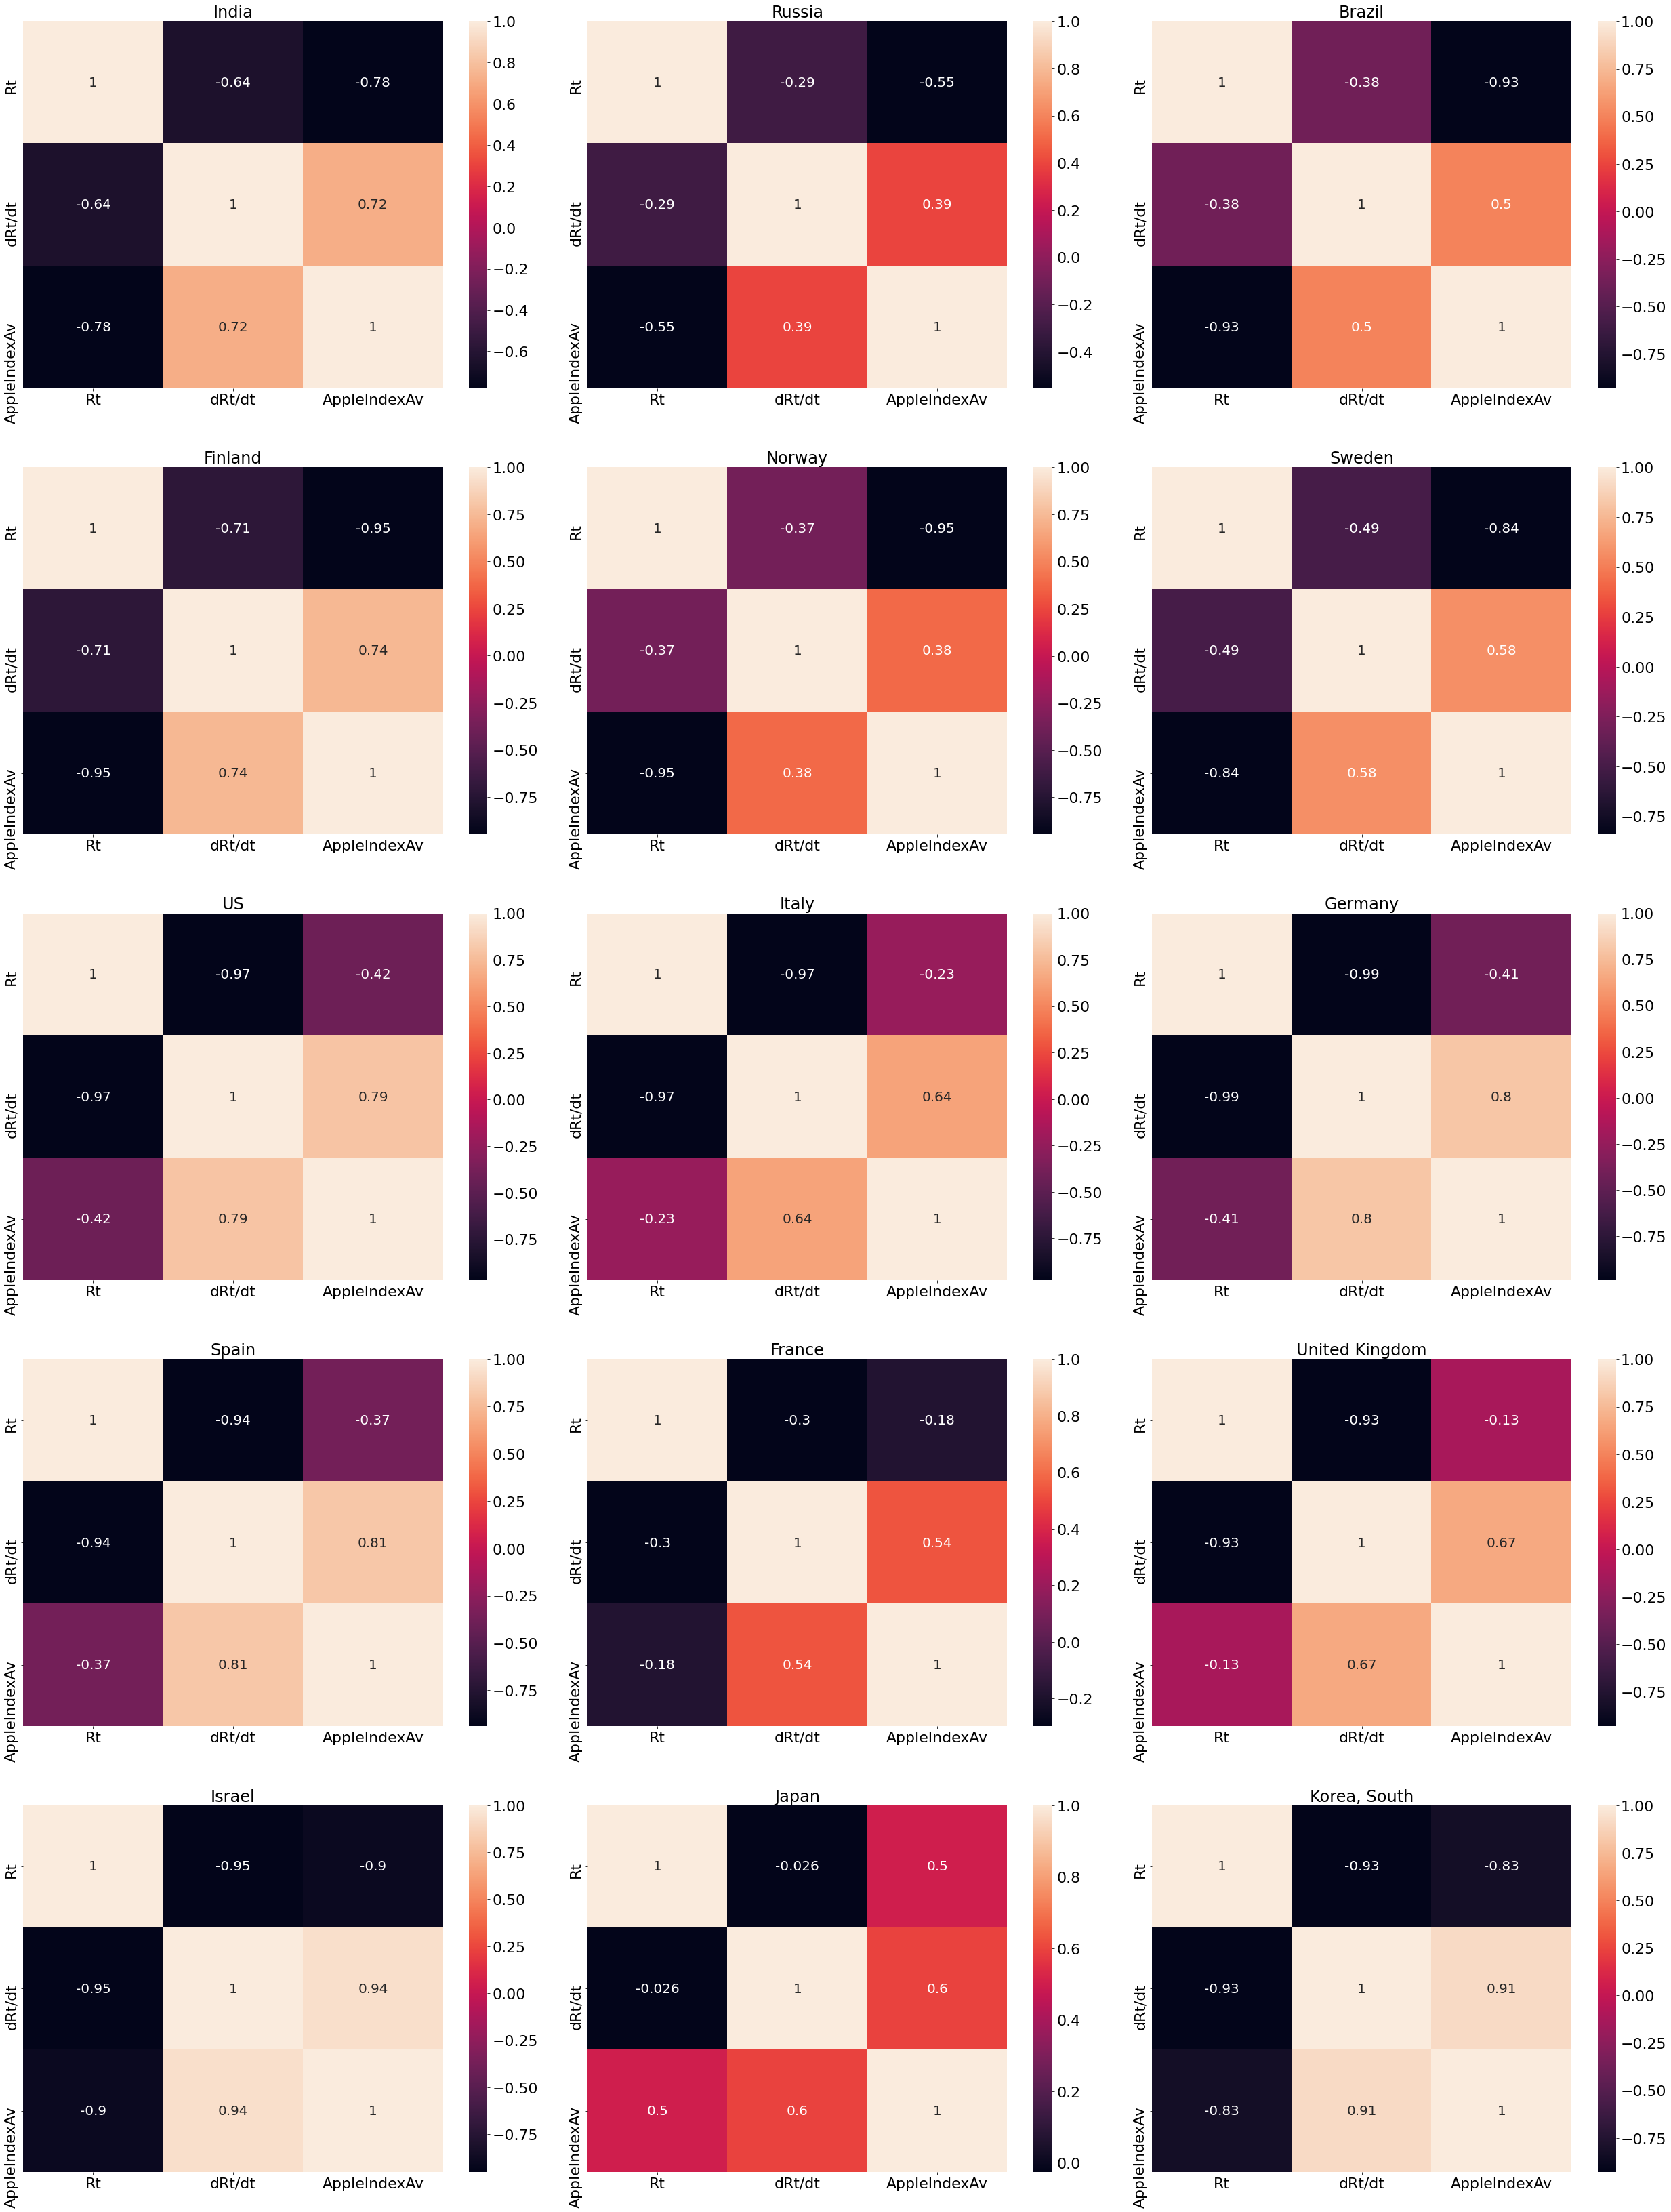

In [86]:
mx = max([len(x) for x in countries])
my = len(countries)
plt.rc('xtick',labelsize=22)
plt.rc('ytick',labelsize=22)
plt.rc('font',size=20)
fig,ax = plt.subplots(my,mx,figsize=(35,46),sharex=False)
for i in range(my):
    for j in range(mx):
        c = countries[i][j]
        pop,df = country_datax[c]
        corrMatrix = country_datax[c][1].drop(['Infected_Av','Recovered_Av','Deaths_Av','Date','Rt_mf','Rt_mf_Av',
                                                'Rt_shift_5','dAppleIndexAv/dt','AppleIndex','Infected','Recovered','Deaths', 'Exposed',	'Removed', 
                                               'Exposed_Av',	'Removed_Av',	
                                               'Beta',	'Gamma',	'Sigma','Days','PI','Delta_Infected_Gr',
                                               'Infected_shift_7'], axis='columns').corr(method='spearman')
        ax3 = sn.heatmap(corrMatrix, annot=True, ax=ax[i,j])
        ax[i,j].set_title(c)
fig.tight_layout()
plt.show()